Example inspired by 
[PyTorch Tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html) for explaining ML terminology.

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

bg = "#383838"
plt.rcParams.update({
    "figure.facecolor": bg,
    "figure.edgecolor": bg,
    "savefig.facecolor": bg,
    "savefig.edgecolor": bg})

torch.__version__

'2.0.0+cu118'

In [ ]:
ds = datasets.MNIST
# ds = datasets.FashionMNIST
training_data = ds(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = ds(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

len(training_data), len(test_data)

(60000, 10000)

In [ ]:
first = training_data[0]
first[0].shape, first[1]

(torch.Size([1, 28, 28]), 5)

5,    0,    4,    1,    9,    2,    1,    3,    1,    4,    

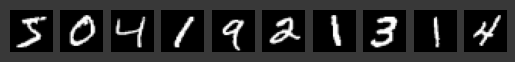

In [ ]:
for i in range(10):
  print(training_data[i][1], end=',    ')

  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(training_data[i][0][0], cmap='gray')

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Linear(28*28, 10) # for each pixel in image and each output category multiply it by weight (w), then for each category add bias (b)
        # self.layers = nn.Sequential(
        #     nn.Linear(28*28, 10),
        #     nn.ReLU(),
        #     # ...
        # )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

model = NeuralNetwork()
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
# model.layers.weight.data.fill_(0.01)
# model.layers.bias.data.fill_(0.01)
model.layers.weight.data, model.layers.bias.data

(tensor([[-9.0349e-03,  5.3291e-03,  2.5955e-02,  ..., -3.3422e-03,
          -5.6225e-03,  1.6547e-02],
         [ 3.4052e-02,  2.3017e-02, -1.4675e-02,  ...,  1.6260e-02,
           3.2667e-02, -4.8776e-03],
         [-1.3981e-02, -7.2632e-03, -1.6890e-02,  ..., -2.1339e-02,
          -3.6693e-03,  2.2111e-02],
         ...,
         [ 2.1930e-02, -1.7316e-02, -2.8703e-03,  ..., -3.3779e-05,
           3.3387e-02, -2.3545e-03],
         [ 2.8816e-03,  1.7490e-02,  2.3678e-02,  ..., -1.8226e-02,
          -3.2558e-02,  2.4380e-03],
         [ 1.5006e-02, -2.6897e-02,  4.0560e-03,  ...,  2.6650e-02,
           1.7819e-02, -1.1566e-02]]),
 tensor([-0.0274,  0.0078,  0.0356,  0.0257,  0.0106, -0.0273,  0.0267, -0.0308,
         -0.0299, -0.0142]))

In [ ]:
x = training_data[0][0]
y = torch.zeros(10)
y[training_data[0][1]] = 1
y # expected output as one-hot encoded probabilities

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [ ]:
out = model(x)
list(enumerate(*out.detach().numpy())) # actual output from model => logits

[(0, 0.1771769),
 (1, -0.19832423),
 (2, -0.20448236),
 (3, 0.28688264),
 (4, 0.18993436),
 (5, 0.19386116),
 (6, 0.18575034),
 (7, -0.05542535),
 (8, -0.13201796),
 (9, -0.017122548)]

In [ ]:
torch.argmax(out) # index of max logit => predicted category

tensor(3)

In [ ]:
torch.softmax(out, 1) # probabilities (convert logits by "some magic" so that all values are between 0 and 1, and the sum is 1)

tensor([[0.1127, 0.0774, 0.0769, 0.1258, 0.1141, 0.1146, 0.1137, 0.0893, 0.0827,
         0.0928]], grad_fn=<SoftmaxBackward0>)

In [ ]:
-torch.log(torch.softmax(out, 1)) # negative logarithm of probabilities => entropy

tensor([[2.1831, 2.5586, 2.5648, 2.0734, 2.1703, 2.1664, 2.1745, 2.4157, 2.4923,
         2.3774]], grad_fn=<NegBackward0>)

In [ ]:
loss_fn = nn.CrossEntropyLoss() # a function that we want to minimize (for every model output on training data compared to desired output)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # side quest: explain stochastic gradient descent and learning rate

train_dataloader = DataLoader(training_data, batch_size=100) # hyper-parametes used in training ("search for program") vs parameters inside the model ("the program we found")
test_dataloader = DataLoader(test_data, batch_size=100)

for epoch in range(1): # epochs vs batches
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        # X, y = X.to(device), y.to(device)  if we would be using GPU/MPU/TPU
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# model prediction after training
out = model(x)
list(enumerate(*out.detach().numpy()))

[(0, -0.59068465),
 (1, -3.2879238),
 (2, -1.3059332),
 (3, 2.4671628),
 (4, -5.3817625),
 (5, 2.6767466),
 (6, -2.2072687),
 (7, -0.09491294),
 (8, -0.7049214),
 (9, -2.1103463)]

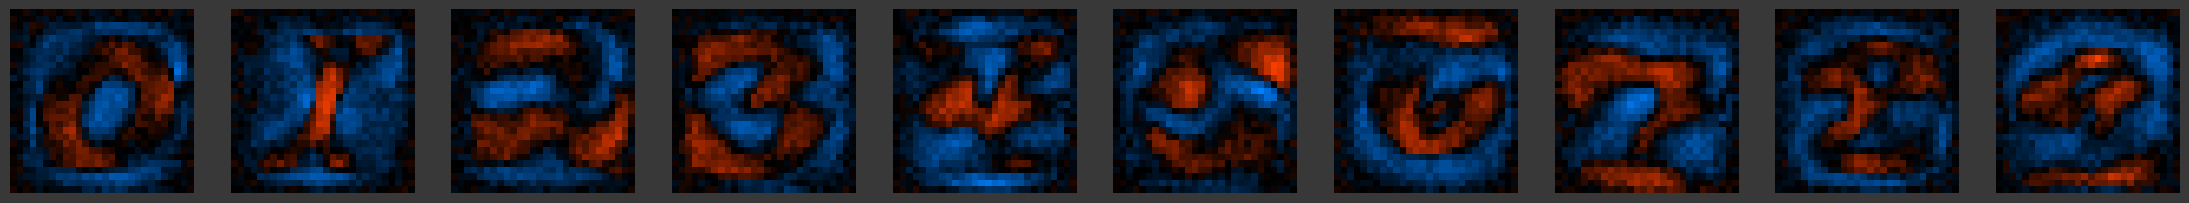

In [ ]:
# 7840 weights after training, visualized as 10 images for output neurons
# red: excitation from a pixel in input image, blue: inhibition, black: no effect

w = model.layers.weight.detach().numpy()
nmin, nmax = w.min(), w.max()
plt.figure(figsize=(28, 28))
for i in range(10):
  n = w[i].reshape(28, 28)
  r = n * (n > 0) / nmax * 255
  b = n * (n < 0) / nmin * 255
  g = r / 4 + b / 2
  img = np.uint8(np.dstack((r, g, b)))
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(img)

In [ ]:
model.layers.bias

Parameter containing:
tensor([-0.1371,  0.1987, -0.0054, -0.0668,  0.0719,  0.1001, -0.0092,  0.0777,
        -0.2176, -0.0323], requires_grad=True)

In [ ]:
np.unique(np.array([i[1] for i in training_data]), return_counts=True) # frequency of each digit in the training data for comparison with bias

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [ ]:
# evaluation on test data

model.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in test_dataloader:
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= len(test_dataloader)
correct /= len(test_dataloader.dataset)
print(f"Test accuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>4f}")

Test accuracy: 90.3%, avg loss: 0.365307
